In [2]:
from neo4j import GraphDatabase
from neo4j import Query
import time
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

## Create Dataset

In [138]:
# define the choice of children patterns.
child_patterns = [['Star', 'E'], ['Star', 'R'], ['A', 'E'], ['A', 'R'], ['M', 'O'], ['O', 'E'], ['O', 'R']]

# Initialize the datasets and the first two node for output
root_pattern = random.choice(child_patterns)    # select a pattern for root
root_1 = root_pattern[0]    # indicate the realtionshiptype for root to 1
output_initial = {'parent':['root'], 'child':['Node1'], 'relationshiptype':[root_1]}

# Define and initialize the nodes we can choose to start and end
nodes_start_initial = {'root':{'children':[['Node1']], 'ancestors':[[]], 'children_pattern':root_pattern}}
nodes_start_initial['Node1'] = {'children':[[]], 'ancestors':[['root']], 'children_pattern':random.choice(child_patterns)} # use the attribute of python shallow copy for ancestors, so that we can do change at same time
nodes_end_initial = {'Node1':{'parent':{root_1:'root'}}}
nodes_start_initial['Node1']['ancestors'].append(nodes_start_initial['root']['ancestors'])
nodes_start_initial['root']['children'].append(nodes_start_initial['Node1']['children'])

# nodes_start['root']['ancestors'][0].append(1) #check for the design
print(output_initial)
print(nodes_start_initial)
print(nodes_end_initial)

{'parent': ['root'], 'child': ['Node1'], 'relationshiptype': ['M']}
{'root': {'children': [['Node1'], [[]]], 'ancestors': [[]], 'children_pattern': ['M', 'O']}, 'Node1': {'children': [[]], 'ancestors': [['root'], [[]]], 'children_pattern': ['Star', 'E']}}
{'Node1': {'parent': {'M': 'root'}}}


In [139]:
# Define function to delete node in nodes_end
def delete_node_end(end_node:str, nodes_start:dict, nodes_end:dict) -> None:
    if len(nodes_end[end_node]['parent']) == 2:
        del nodes_end[end_node]
    ## 'E', 'R' cannot point to a parent have 'M' relationship
    if nodes_start[end_node]['children_pattern'] == ['M','O']:
        del nodes_end[end_node]

# delete_node_end('Node1', nodes_end_initial)

# Define function to treat the list as string to get the ancestors and children
def flatten_nested_list(nested_list):
    flattened_str = str(nested_list).replace('[','').replace(']','').replace("'",'').split(', ')
    return [item for item in flattened_str if item]

# Define function to get a node's nonancestors
def get_nonancestor(start_node:str, nodes_start:dict,nodes_end:dict):
    ancestors = flatten_nested_list(nodes_start[start_node]['ancestors'])
    nonancestors = [item for item in list(nodes_end.keys()) if item not in ancestors+[start_node]+nodes_start[start_node]['children'][0]]
    # print(ancestors+[start_node]+nodes_start[start_node]['children'][0],nonancestors)
    return [ancestors,nonancestors]

# Define function to get a node's nonchildren
def get_nonchildren(start_node:str, nodes_start:dict, nodes_end:dict):
    children = flatten_nested_list(nodes_start[start_node]['children'])
    nonchildren = [item for item in list(nodes_end.keys()) if item not in children+[start_node]]
    # print(children+[start_node],nonchildren)
    return [children,nonchildren]

# Define function to add relationship to the graph
def add_relationship(nodes_start: dict, nodes_end: dict, output: dict, node_count, child_patterns = child_patterns):
    start_node = random.choice(list(nodes_start.keys())) # select the start node
    end_node_type = random.choice(['new','old'])    # select a type for end_node with probability 0.5

    if  len(nodes_end) != 0:    # get the nonancestor list
        end_node = random.choice(list(nodes_end.keys()))    # set a old nodes for the temp selected end_node
        nonancestor = get_nonancestor(start_node,nodes_start, nodes_end)[1]  # get the nonancestors for temp selected end_node
        # nonchildren = get_nonchildren(start_node, nodes_start, nodes_end)[1] # get non children

    if len(nodes_end) == 0 or len(nonancestor) == 0 or nodes_start[start_node]['children_pattern'] == ['M', 'O']: # set the type to new when there's not a choice
        end_node_type = 'new'

    if end_node_type == 'old':   # update data if type = 'old'   
        end_node = random.choice(nonancestor)   # choose the start node for this situation.
        # print('old',start_node,end_node,nodes_start[start_node]) # code for check
        node_pattern = nodes_start[start_node]['children_pattern'][1] # get the pattern for end_node
        if nodes_start[start_node]['children'] == [[]]:
            node_pattern = nodes_start[start_node]['children_pattern'][0] # avoid only E,R appears in this case       
        
        # updata nodes_end
        nodes_end[end_node]['parent'][node_pattern] = start_node    # update nodes_end with new relationship
        del nodes_end[end_node] # delete the nodes that cannot be selected anymore
        
        # updata output
        output['parent'].append(start_node)
        output['child'].append(end_node)
        output['relationshiptype'].append(node_pattern)
        
        # updata nodes_start
        nodes_start[start_node]['children'][0].append(end_node)
        nodes_start[start_node]['children'].append(nodes_start[end_node]['children'])
        nodes_start[end_node]['ancestors'][0].append(start_node)
        nodes_start[end_node]['ancestors'].append(nodes_start[start_node]['ancestors'])

    else:   # update data if type = 'new' 
        # print('new', start_node,nodes_start[start_node])  # code for check
        node_pattern = nodes_start[start_node]['children_pattern'][0]   # should not get a 'E' or 'R'relaitonship with new node,incase it just end with it finally
        if nodes_start[start_node]['children_pattern'] == ['M','O']:
            node_pattern = random.choice(['M','O'])
        end_node = 'Node' + str(node_count) # Define the name for new node
        node_count += 1 # update node_count

        # update output
        output['parent'].append(start_node)
        output['child'].append(end_node)
        output['relationshiptype'].append(node_pattern)

        # update nodes_end
        nodes_end[end_node] = {'parent':{}} # initialize node_end for new node
        nodes_end[end_node]['parent'][node_pattern] = start_node    # update nodes_end with new relationship
        
        # update nodes_start
        new_node_pattern = random.choice(child_patterns) # select a pattern for new node
        # print(new_node_pattern) # code for check
        nodes_start[end_node] = {'children':[[]], 'ancestors':[[]], 'children_pattern':new_node_pattern} # initialize node_end for new node
        nodes_start[start_node]['children'][0].append(end_node)
        nodes_start[start_node]['children'] = nodes_start[start_node]['children'] + nodes_start[end_node]['children']
        nodes_start[end_node]['ancestors'][0].append(start_node)
        # print(nodes_start[end_node]['ancestors'][-1])
        nodes_start[end_node]['ancestors'].append(nodes_start[start_node]['ancestors'])
        delete_node_end(end_node,nodes_start,nodes_end) # delete the nodes that cannot be selected anymore

    return [nodes_start, nodes_end, output, node_count]
        
        


In [146]:
import copy
# Define how many rows we want
num_rows1 = 500 - 1
num_rows2 = 1000 - 1
num_rows3 = 10000 - 1
num_rows4 = 20000 - 1

# Initialize the parameters
output,nodes_start,nodes_end = copy.deepcopy(output_initial),copy.deepcopy(nodes_start_initial),copy.deepcopy(nodes_end_initial)
node_count = len(nodes_start)
# print(output,'\n',nodes_start,'\n',nodes_end,'\n',node_count) #code for check initial
# run and get output with size 500
for _ in range(num_rows1):
    nodes_start, nodes_end, output, node_count = add_relationship(nodes_start, nodes_end, output, node_count, child_patterns)
output_500 = output

# run with size 1k
output,nodes_start,nodes_end = copy.deepcopy(output_initial),copy.deepcopy(nodes_start_initial),copy.deepcopy(nodes_end_initial)
node_count = len(nodes_start)
# print(output,'\n',nodes_start,'\n',nodes_end,'\n',node_count) # code for check initial
for _ in range(num_rows2):
    nodes_start, nodes_end, output, node_count = add_relationship(nodes_start, nodes_end, output, node_count, child_patterns)
output_1k = output

# run with size 10k
output,nodes_start,nodes_end = copy.deepcopy(output_initial),copy.deepcopy(nodes_start_initial),copy.deepcopy(nodes_end_initial)
node_count = len(nodes_start)
for _ in range(num_rows3):
    nodes_start, nodes_end, output, node_count = add_relationship(nodes_start, nodes_end, output, node_count, child_patterns)
output_10k = output

# run with size 20k
output,nodes_start,nodes_end = copy.deepcopy(output_initial),copy.deepcopy(nodes_start_initial),copy.deepcopy(nodes_end_initial)
node_count = len(nodes_start)
for _ in range(num_rows4):
    nodes_start, nodes_end, output, node_count = add_relationship(nodes_start, nodes_end, output, node_count, child_patterns)
output_20k = output

In [147]:
data_500 = pd.DataFrame(output_500)
data_1k = pd.DataFrame(output_1k)
data_10k = pd.DataFrame(output_10k)
data_20k = pd.DataFrame(output_20k)
data_500.to_csv("data_500.csv", index=False)
data_1k.to_csv("data_1k.csv", index=False)
data_10k.to_csv("data_10k.csv", index=False)
data_20k.to_csv("data_20k.csv", index=False)

In [120]:
# # illustration of the code
# def flatten_nested_list(nested_list):
#     flattened_str = str(nested_list).replace('[','').replace(']','').replace("'",'').split(', ')
#     return [item for item in flattened_str if item]

# nested_list = [['Node1'], [['root', 'Node1'], [[]], [['root', 'Node1'], [[]], [['root'], [[]]]]]]

# result = flatten_nested_list(nested_list)
# print(result)

# A = [[1,2]]
# B = [[3,4]]
# C = [[5,6]]
# # for i in range(len(B[0])):
# C.append(B)
# B.append(A)
# print(A,B,C)
# A[0].append(5)
# print(A,B,C)

[[1, 2]] [[3, 4], [[1, 2]]] [[5, 6], [[3, 4], [[1, 2]]]]
[[1, 2, 5]] [[3, 4], [[1, 2, 5]]] [[5, 6], [[3, 4], [[1, 2, 5]]]]


## Load data

In [60]:
# Please put the csv file to the neo4j database folder first!!!

#Establishing a connection to the Neo4j database
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "12345678"))

def load_session(database_name, filepath)->None:
    #Using the connection to run a session
    with driver.session(database=database_name) as session:
    #Query to load a CSV file (attached on BB). 
        #You can break the long Cypher query into multiple lines in Python using triple-quoted stringse:
        loadQuery = f"""
        LOAD CSV WITH HEADERS FROM '{filepath}' AS line
        MERGE (n:Node {{name: line.child}})
        MERGE (m:Node {{name: line.parent}})
        MERGE (n)<-[r:isParentOf {{rType: line.relationshiptype}}]-(m)
        """
        #Record the start time before executing the query to load data
        loadStartTime = time.time()

        #Execute the query to load data
        LoadResult = session.run(loadQuery)

        #Record the end time after executing the query to load data
        LoadEndTime = time.time()

        #Calculate and print the time taken to execute the query for loading data
        print("\n\nThe execution time to load the CSV file to Neo4j is :", LoadEndTime - loadStartTime, "seconds\n")

In [149]:
load_session('assign3data500','file:///data_500.csv')
load_session('assign3data1k','file:///data_1k.csv')
load_session('assign3data10k','file:///data_10k.csv')
load_session('assign3data20k','file:///data_20k.csv')



The execution time to load the CSV file to Neo4j is : 237.70694518089294 seconds



## Queries

In [7]:
# intialize output
results = {'DFS':{'Cypher':[],'data_science_library':[],'APOC':[]},'BFS':{'Cypher':[],'data_science_library':[],'APOC':[]}}

driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "12345678"))
# Define function
def run_query(database_name, Query):
    with driver.session(database=database_name) as session:

        #Record the start time before executing the query to load data
        loadStartTime = time.time()

        #Execute the query to load data
        LoadResult = session.run(Query)

        #Record the end time after executing the query to load data
        LoadEndTime = time.time()

        #Calculate and print the time taken to execute the query for loading data
        # print("\n\nThe execution time to load the CSV file to Neo4j is :", LoadEndTime - loadStartTime, "seconds\n")
        return LoadEndTime - loadStartTime

In [8]:
# Define the queries
DFS_Cypher = """
MATCH (start:Node {name: 'root'})
WITH start
MATCH path = (start)-[:isParentOf*]->()
RETURN path
"""
BFS_Cypher = """
MATCH (start:Node {name: 'root'})
WITH start
MATCH (end:Node) 
WHERE (start)-[:isParentOf*1..]->()
RETURN DISTINCT end
"""

DFS_data_science_library = """
MATCH (source:Node{name:'root'})
CALL gds.dfs.stream('myGraph', {
  sourceNode: source
})
YIELD path
RETURN path
"""
BFS_data_science_library ="""
MATCH (source:Node{name:'root'})
CALL gds.bfs.stream('myGraph', {
  sourceNode: source
})
YIELD path
RETURN path
""" 

DFS_APOC = """
MATCH (startNode:Node {name: 'root'})
CALL apoc.path.expandConfig(startNode, {strategy: 'DFS', relationshipFilter: 'isParentOf>'}) YIELD path
RETURN path
"""
BFS_APOC = """
MATCH (startNode:Node {name: 'root'})
CALL apoc.path.expandConfig(startNode, {strategy: 'BFS', relationshipFilter: 'isParentOf>'}) YIELD path
RETURN path
"""

In [9]:
# Cypher queries:
results['DFS']['Cypher'].append(run_query('assign3data500',DFS_Cypher))
results['BFS']['Cypher'].append(run_query('assign3data500',BFS_Cypher))
results['DFS']['Cypher'].append(run_query('assign3data1k',DFS_Cypher))
results['BFS']['Cypher'].append(run_query('assign3data1k',BFS_Cypher))
results['DFS']['Cypher'].append(run_query('assign3data10k',DFS_Cypher))
results['BFS']['Cypher'].append(run_query('assign3data10k',BFS_Cypher))
results['DFS']['Cypher'].append(run_query('assign3data20k',DFS_Cypher))
results['BFS']['Cypher'].append(run_query('assign3data20k',BFS_Cypher))

In [10]:
# data science library queries:
run_query('assign3data500',"""CALL gds.graph.project('myGraph', 'Node', 'isParentOf')""")
results['DFS']['data_science_library'].append(run_query('assign3data500',DFS_data_science_library))
results['BFS']['data_science_library'].append(run_query('assign3data500',BFS_data_science_library))
run_query('assign3data1k',"""CALL gds.graph.project('myGraph', 'Node', 'isParentOf')""")
results['DFS']['data_science_library'].append(run_query('assign3data1k',DFS_data_science_library))
results['BFS']['data_science_library'].append(run_query('assign3data1k',BFS_data_science_library))
run_query('assign3data10k',"""CALL gds.graph.project('myGraph', 'Node', 'isParentOf')""")
results['DFS']['data_science_library'].append(run_query('assign3data10k',DFS_data_science_library))
results['BFS']['data_science_library'].append(run_query('assign3data10k',BFS_data_science_library))
run_query('assign3data20k',"""CALL gds.graph.project('myGraph', 'Node', 'isParentOf')""")
results['DFS']['data_science_library'].append(run_query('assign3data20k',DFS_data_science_library))
results['BFS']['data_science_library'].append(run_query('assign3data20k',BFS_data_science_library))

In [11]:
# APOC library queries:
results['DFS']['APOC'].append(run_query('assign3data500',DFS_APOC))
results['BFS']['APOC'].append(run_query('assign3data500',BFS_APOC))
results['DFS']['APOC'].append(run_query('assign3data1k',DFS_APOC))
results['BFS']['APOC'].append(run_query('assign3data1k',BFS_APOC))
results['DFS']['APOC'].append(run_query('assign3data10k',DFS_APOC))
results['BFS']['APOC'].append(run_query('assign3data10k',BFS_APOC))
results['DFS']['APOC'].append(run_query('assign3data20k',DFS_APOC))
results['BFS']['APOC'].append(run_query('assign3data20k',BFS_APOC))

In [12]:
print(results)

{'DFS': {'Cypher': [2.644958257675171, 0.19747185707092285, 0.19931340217590332, 0.1999807357788086], 'data_science_library': [0.12167596817016602, 0.2326371669769287, 0.17553234100341797, 0.1156911849975586], 'APOC': [0.294208288192749, 0.074798583984375, 0.09275484085083008, 0.08677434921264648]}, 'BFS': {'Cypher': [0.426450252532959, 0.2373650074005127, 0.22041034698486328, 0.1825120449066162], 'data_science_library': [0.12666058540344238, 0.15858030319213867, 0.08672094345092773, 0.08473420143127441], 'APOC': [0.02692866325378418, 0.03191542625427246, 0.022944927215576172, 0.017952919006347656]}}


## Plot the results

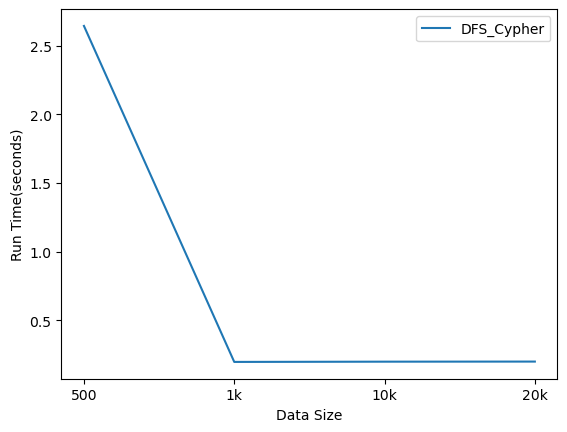

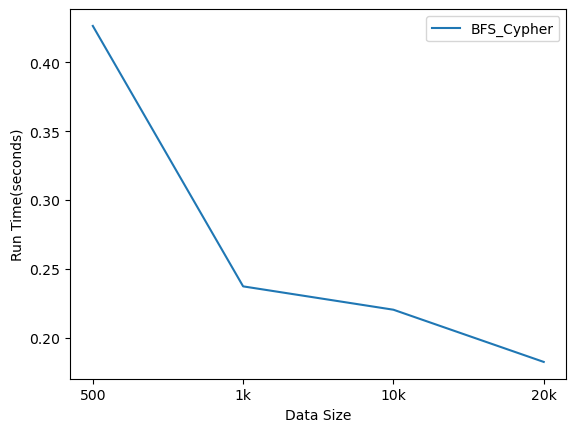

In [16]:
plt.plot(['500','1k','10k','20k'],results['DFS']['Cypher'] ,label = 'DFS_Cypher')
plt.xlabel('Data Size')
plt.ylabel('Run Time(seconds)')
plt.legend()
plt.show()
plt.plot(['500','1k','10k','20k'],results['BFS']['Cypher'] ,label = 'BFS_Cypher')
plt.xlabel('Data Size')
plt.ylabel('Run Time(seconds)')
plt.legend()
plt.show()

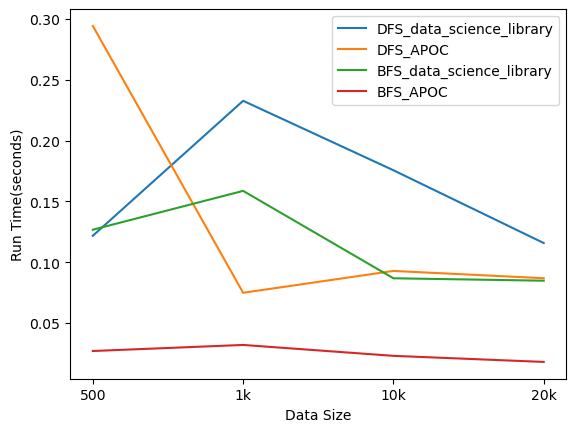

In [14]:
for key1 in results.keys():
    for key2 in list(results[key1].keys())[1:]:
        plt.plot(['500','1k','10k','20k'],results[key1][key2] ,label = key1+ '_' + key2)
plt.xlabel('Data Size')
plt.ylabel('Run Time(seconds)')
plt.legend()
plt.show()

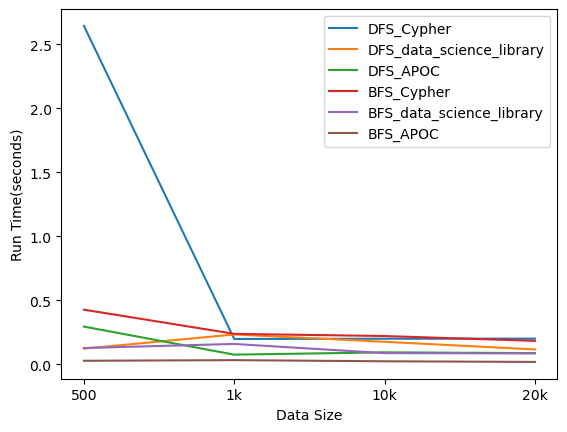

In [13]:
import matplotlib.pyplot as plt

for key1 in results.keys():
    for key2 in results[key1].keys():
        plt.plot(['500','1k','10k','20k'],results[key1][key2] ,label = key1+ '_' + key2)
plt.xlabel('Data Size')
plt.ylabel('Run Time(seconds)')
plt.legend()
plt.show()